In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import sys
sys.path.append('../python')
import dataPython as dp
import scipy.interpolate as inter

from datetime import datetime
import scipy.integrate as si
import noordermeer as noord
import time

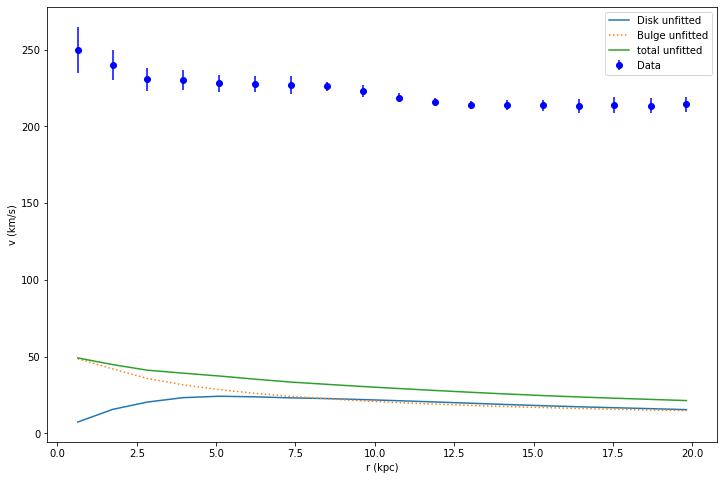

In [31]:
'''
source [1]: 
https://www.aanda.org/articles/aa/pdf/2011/07/aa16634-11.pdf
run in gipsy
Zlaw = sech-squared ???
Z0=.88 kpc (paper table 4 gives hz=.44kpc where z0=2*hz)
D=14.6 Mpc (paper table 1)
density profile Y
UNITS=kpc,mag/arcsec**2
RADDENS=<NGC7814disk4  <-- note that gipsy doesn't like scientific notation, i.e. 1.534e2 should be 153.4
MASS=1 ???? (stellar mass....)
RADII=0,0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
(same points as raw data, table 3)
'''




#********************automatically replacing '!' with '#' so python doesn't throw hissy fit
import fileinput

with fileinput.FileInput('../testing/7814reallybulge.dat', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('!','#'), end='')
        
with fileinput.FileInput('../testing/7814reallydisk.dat', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('!','#'), end='')

#**********************importing text files******************************
#there's no need to import the radius for each component as everything has the same r array (the r array of the raw data)
#data:
data = dp.getXYdata_wXYerr('ngc7814data')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err1 = np.asarray(data['ey'])
#disk:
disk = dp.getXYZdata('../testing/7814reallydisk.dat')
d = np.asarray(disk['zz'])
#bulge:
bulge = dp.getXYZdata('../testing/7814reallybulge.dat')
b = np.asarray(bulge['zz'])



#***************************define total curve
#D=9.25 #disk M-L ratio provided in [1] 
#B=.5 #bulge M-L ratio provided in [1] 
def t(B,D):
    return np.sqrt((D*d)**2
                   + (B*b)**2
                  )
plt.figure(figsize=(12,8))
plt.plot(r,d,label='Disk unfitted') 
'''
GIPSY input:
disk
Zlaw = sech-squared
Z0=.88
UNITS=kpc,msun/pc**2
RADDENS=<7814diskdecomp4
MASS=1
RADII=0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
'''
plt.plot(r,b,':',label='Bulge unfitted') 
'''
GIPSY input:
bulge
UNITS=kpc,msun/pc**2
RADDENS=<7814bulgedecomp3 
MASS=1
RADII=0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
'''
plt.plot(brb,t(1,1),label='total unfitted')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')

plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
plt.legend()
plt.show()

## paper uses extrapolated photometric profile (fig 7), not the actual points (provided by sparc)????

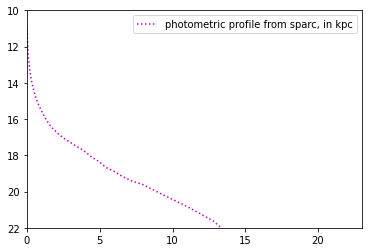

In [3]:
# https://iopscience.iop.org/article/10.3847/0004-6256/152/6/157 fig 5

fromplot_import = dp.getXYdata('NGC7814photometric.rcl')
r_fromplot = fromplot_import['xx']
v_fromplot = fromplot_import['yy']
v_fromplotZ=np.array(v_fromplot)
#vvvv=np.array([r_fromplotZ]).T
D=14.6e3 #kpc
r_fromplotZ= D*np.tan(np.radians(np.array(r_fromplot)/3600)) #convert angular distance (arcsec) to linear distance (kpc)
#print(v_fromplot)
#print(r_fromplot)
#zipped = zip(r_fromplot, v_fromplot)
#zipped = zip(r_fromplotZ, v_fromplotZ)

dat = np.array([r_fromplotZ, v_fromplotZ])
dat = dat.T
np.savetxt('data.rcl', dat, delimiter = '	 ')
rrrr=np.array([r_fromplotZ]).T

plt.figure(figsize=(6,4))
r_fromplot2 = r_fromplot[44:]
v_fromplot2 = v_fromplot[44:]

m, b = np.polyfit(r_fromplot2, v_fromplot2, 1)
def y(x):
    return m*x+b
x0=r_fromplot[-1:] #the very last element of radius array, to be used as last element in new radius array
x=np.linspace(0,x0,100)
#turn x and y column vectors into (horizontal) arrays
y=y(x).T
x=x.T
#remove the redudant bracket by calling the "nested" bracket
y=y[0]
x=x[0]
dat = np.array([x, y])
dat = dat.T
np.savetxt('../testing/lineardiskasec4.rcl', dat, delimiter = '	 ',fmt='%f')
#plt.plot(x,y(x),markersize=30,label='extraopolation of profile, used in [1]?')
#plt.plot(r_fromplot,v_fromplot,':',color='m',markersize=10,label='photometric profile from sparc in arcsec')
plt.plot(r_fromplotZ,v_fromplot,':',color='m',markersize=10,label='photometric profile from sparc, in kpc')


plt.xlim([0,23])
plt.ylim([10,22])
plt.gca().invert_yaxis()
plt.legend()
plt.show()



In [24]:
'''
SEPARATING SPARC DECOMP INTO JUST DISK AND JUST BULGE... FOR GIPYSY...
note that for some reason the files must be saved in the testing folder, otherwise I can't push the files to Kitty...
'''
decomp = dp.getXYZdata('NGC7814_decomp.dens')
r_decomp = decomp['xx'] #units kpc
d_decomp = decomp['yy'] #Lsun/pc**2 (i.e. Msun/pc**2 w/o the M-L ratio)
b_decomp = decomp['zz'] #Lsun/pc**2 

#gipsy doesn't like any values >=0, so remove first element... is there a better way to do this???
del r_decomp[0]
del d_decomp[0]
del b_decomp[0]
#notes: gipsy don't like more than 3 decimals. gipsy also don't like values of zero!!! (i.e the first point in the data file)
dfile = np.array([r_decomp, d_decomp])
dfile = dfile.T
np.savetxt('../testing/7814diskdecomp2.rcl', dfile, delimiter = '	 ',fmt='%.3f')
'''
Gipsy input:

'''




bfile = np.array([r_decomp, b_decomp])
bfile = bfile.T
np.savetxt('../testing/7814bulgedecomp.rcl', bfile, delimiter = '	 ',fmt='%.3f')



In [5]:
'''
what i've learned:
gipsy doesn't like scientific notation for data files
the sparc photometric radius data is in arcsec
gipsy can use arcsec as a radius unit input







'''

"\nwhat i've learned:\ngipsy doesn't like scientific notation for data files\nthe sparc photometric radius data is in arcsec\ngipsy can use arcsec as a radius unit input\n\n\n\n\n\n\n\n"